# Assignment 3: Linear Regression (100 points)

Only use the already imported library `numpy` and the Python standard library. Make sure that the datasets `dataLinReg2D.txt`, `dataQuadReg2D.txt` and `dataQuadReg2D_noisy.txt` are in the same directory as the notebook.


==> *Write*
* *names* 
* *matr. nr.* 
* *study program*
* *B.Sc./M.Sc.*

*of all assignment group participants here. (double klick here to edit)*

## Task 1: Linear Regression - theory (10 points)
1) *(4 points)* Linear regression can have nonlinear input features, why is it still called linear regression? In what sense is it linear?

- it is linear in the weights $X\beta$
- the input $X$ can be replaced by arbitrary non-linear features

2) *(3 points)* For calculating optimal parameters $\hat{\beta}$ the inverse of $X^{\top}X$ has to be calculated. When would this matrix be singular?

- if the colums of $X$ are not linearly independet, e.g. `X[:, 1] = 3*X[:, 0]`

3) *(3 points)* Why does the optimization problem for $L_1$-regularization (Lasso) not have a closed form solution?

- $|\beta|$ is not continous differentiable

## Task 2: Ridge Regression for Polynomial 2D Functions (70 points)
Each line in the data sets consists of a data entry `(x,y)` with a 2D point `x` and a 1D function output `y`.

In [1]:
# Load required packages and datasets. Do not modify.
import numpy as np


def load_dataset(path):
    data = np.loadtxt(path)
    X, y = data[:, :2], data[:, 2]
    
    return X, y
    

X_lin, y_lin = load_dataset("dataLinReg2D.txt")
X_quad, y_quad = load_dataset("dataQuadReg2D.txt")
X_noise, y_noise = load_dataset("dataQuadReg2D_noisy.txt")

1) *(5 points)* Draw random samples from the dataset for training, use 70% of the data. Do not modify the interface of the function. Do this for `X_quad` and `X_noise`.

In [2]:
def train_split(X, y, test_split = 0.7):
    """
    Returns X_train, y_train
        where X_train are random samples of X and y_train are the corresponding true values.
        test_split represents the persentage of how many training samples are drawn from X.
    """
    np.random.seed(2021)  # Ensure that the random split always returns the same result.
    
    n, d = X.shape
    n_train_samples = int(test_split * n)
    
    # merge datapoint and function value in one matrix
    X_and_y = np.block([[X, y.reshape((n, 1))]])
    np.random.shuffle(X_and_y)
    # split
    X = X_and_y[:, :d]
    y = X_and_y[:, -1]
    X_train = X[:n_train_samples]
    y_train = y[:n_train_samples]
    
    return X_train, y_train

X_quad_train, y_quad_train = train_split(X_quad, y_quad)
X_noise_train, y_noise_train = train_split(X_noise, y_noise)

2) *(10 points)* Extend the `make_features` method to also compute quadratic features (`ftype = 'quad'`).

In [3]:
def make_features(X, ftype='lin'):
    """
    generates features from input data, returns Phi.
    ftype is used to distinguish types of features
    """
    n, d = X.shape
    
    if ftype == 'lin': 
        # Linear feature transformation (including intercept)
        Phi = np.empty((n, d+1))
        Phi[:, 0] = 1
        Phi[:, 1:] = X
        
    elif ftype == 'quad':
        # Quadratic feature transformation
        Phi = np.empty((n, int(1+d+((d*(d+1))/2))))
        Phi[:, 0] = 1
        Phi[:, 1:1+d] = X
        Phi[:, 3] = X[:, 0]*X[:, 0]
        Phi[:, 4] = X[:, 0]*X[:, 1]
        Phi[:, 5] = X[:, 1]*X[:, 1]
    
    else:
        raise Exception(f'Feature type {ftype} not implemented yet')
    

    return Phi

3) *(10 points)* Implement Ridge Regression to fit a polynomial function to the data sets with the regularization parameter `lambda_` and feature type `ftype`.

Fill out the methods in `RidgeRegression` to train (`fit`) and predict (`predict`). Feel free to introduce new fields and methods based on your needs, but the methods `fit` and `predict` are required and their interface should not be changed. You need to store the vector of regression coefficients in the field `self.beta`. Before calculating the inverse check if the determinant is non-zero.

In [16]:
class RidgeRegression(object):
    def __init__(self, lambda_, ftype = 'lin'):
        self.lambda_ = lambda_
        self.ftype = ftype
        self.beta = None  # Learned regression coefficients.
    
    def fit(self, X, y):
        """
        X is an array of shape (n, d), 
            where n is the number of samples and d is the number of features.
        y is an array of shape (n,)
        """
        
        Phi = make_features(X, self.ftype)
        k = Phi.shape[1]
        I = np.eye(k)
        # \beta_0 is not regularized
        I[0, 0] = 0
        
        # check if inverse exists
        if np.linalg.det((Phi.T @ Phi)) == 0:
            raise Exception(f'The Matrix Phi.T*Phi is singual and cannot be inverted.')
        else:
            # Computing the inverse can be inefficient and inaccurate
            # an alternative to speed up computation would be to solve the linear equation
            # Ax=b, where A = \Phi^{\top}\Phi + \lambda I and b = \Phi^{\top} y
            # self.beta = np.linalg.solve((Phi.T @ Phi) + (self.lambda_ * I), Phi.T @ y)
            self.beta = np.linalg.inv((Phi.T @ Phi) + (self.lambda_ * I)) @ Phi.T @ y
    
    def predict(self, X):
        """
        X is an array with shape (n, d).
        The method returns an array of shape (n,).
        """
        Phi = make_features(X, self.ftype)
        
        return Phi.dot(self.beta)

4) *(5 points)* Implement the function `MSE` to compute the mean squared error. `y_pred` and `y_true` are the vectors of predicted and true function outputs respectively with shape `(n,)`, where `n` is the number of samples. The function returns a single float.

In [17]:
def MSE(y_pred, y_true):
    """
    return the mean squared error of y_pred and y_true
    """
    diff = y_pred - y_true
    return np.dot(diff, diff)/y_true.size

5) *(30 points)* Evaluate your Ridge Regression model with linear features on the linear `(X_lin, y_lin)` data set. Report the MSE on the full data set when trained on the full dataset. Repeat this for different Ridge regularization parameters `lambda_` and generate a nice plot of the MSE for various `lambda_`. Plot the values of `lambda_` on the x-axis on a logarithmical scale and the error on the y-axis. print the minimal `lambda_`.

How does it perform with quadratic features on this data set?

Lambda:1e-05
MSE (lin): 0.010247981453724932
MSE (quad): 0.009745481794512038


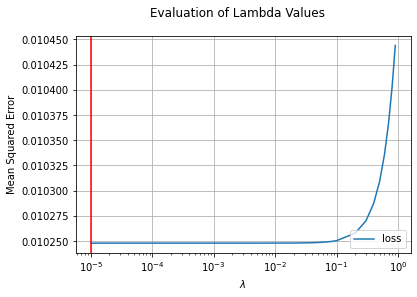

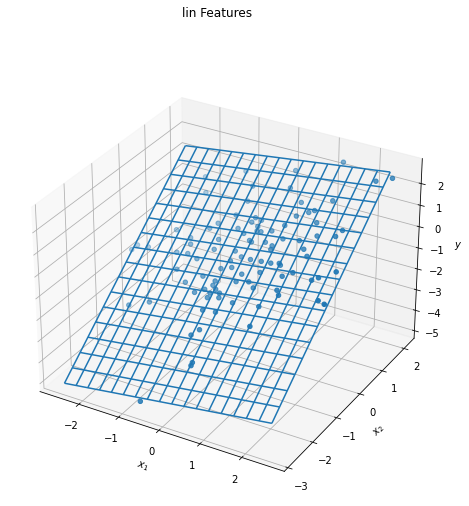

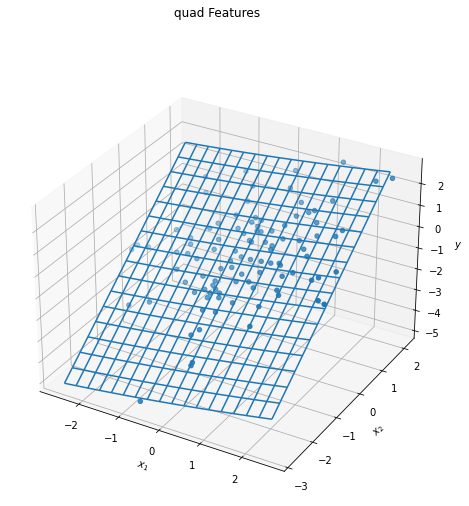

In [18]:
import matplotlib.pyplot as plt

def train_evaluate(regression_model, X, y):
    """
    Use X and y to fit the regression_model and make prediction over the same dataset.
    Print the error
    """
    regression_model.fit(X, y)
    y_hat = regression_model.predict(X)
    print(f'MSE ({regression_model.ftype}): {MSE(y_hat, y)}')
    
def plot_data_and_model(regression_model, X, y):
    """
    Generates a 3D plot of the regression result including the true underlying data.
    The data points are indicated by circles, the prediction is shown as a surface
    """
    fig = plt.figure(figsize=(8, 8))
    plt.suptitle(f'{regression_model.ftype} Features')
    ax = fig.add_subplot(111, projection = '3d')
    ax.scatter(X[:, 0], X[:, 1], y, marker = 'o')
    
    x_min = X.min(0)
    x_max = X.max(0)

    x0_grid, x1_grid = np.mgrid[x_min[0]:x_max[0]:.3, x_min[1]:x_max[1]:.3]

    x_dim_0, x_dim_1 = np.shape(x0_grid)
    x_size = np.size(x0_grid)

    x0_hat = x0_grid.flatten()
    x1_hat = x1_grid.flatten()
    x0_hat = x0_hat.reshape((np.size(x0_hat), 1))
    x1_hat = x1_hat.reshape((np.size(x1_hat), 1))
    x_hat = np.append(x0_hat, x1_hat, 1)
    x_hat_fv = make_features(x_hat, regression_model.ftype)
    y_hat = x_hat_fv.dot(regression_model.beta)
    y_grid = y_hat.reshape((x_dim_0, x_dim_1))
    ax.plot_wireframe(x0_grid, x1_grid, y_grid)
    ax.auto_scale_xyz([x_min[0], x_max[0]], [x_min[1], x_max[1]], [y.min(), y.max()])
    ax.set_xlabel('$x_1$')
    ax.set_ylabel('$x_2$')
    ax.set_zlabel('$y$')
    
lambdas = np.outer(10. ** np.arange(-5, 0), np.arange(1,10,1)).ravel()
loss = np.zeros(lambdas.size)
for i in range(lambdas.size):
    regression_lin = RidgeRegression(lambda_=lambdas[i], ftype='lin')
    regression_lin.fit(X_lin, y_lin)
    y_hat = regression_lin.predict(X_lin)
    loss[i] = MSE(y_hat, y_lin)
li = loss.argmin()
print(f'Lambda:{lambdas[li]}')

plt.figure()
plt.grid()
plt.semilogx(lambdas, loss, label='loss')
plt.axvline(lambdas[li], color='r')
plt.suptitle('Evaluation of Lambda Values')
plt.xlabel('$\lambda$')
plt.ylabel('Mean Squared Error')
plt.legend(loc=4)

# use best lambda with linear features
regression_lin = RidgeRegression(lambda_=lambdas[li], ftype='lin')
train_evaluate(regression_lin, X_lin, y_lin)
plot_data_and_model(regression_lin, X_lin, y_lin)

# use best lambda with quadratic features
regression_lin = RidgeRegression(lambda_=lambdas[li], ftype='quad')
train_evaluate(regression_lin, X_lin, y_lin)
plot_data_and_model(regression_lin, X_lin, y_lin)

6) *(5 points)* Evaluate the quadratic dataset `(X_quad, y_quad)` for different values of `lambda_`. Report the MSE on the full data set when trained on the partial dataset `(X_quad_train, y_quad_train)`. Repeat this for different Ridge regularization parameters `lambda_` and generate a nice plot of the MSE for various `lambda_`. Plot the values of `lambda_` on the x-axis on a logarithmical scale and the error on the y-axis. print the minimal `lambda_`.

Plot the surface and data points of the best `lambda_` value using the function `plot_data_and_model`.

Lambda: 0.09
MSE (quad): 0.011884546968935886


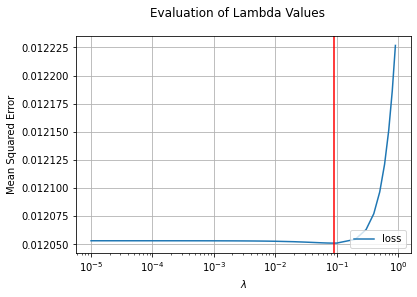

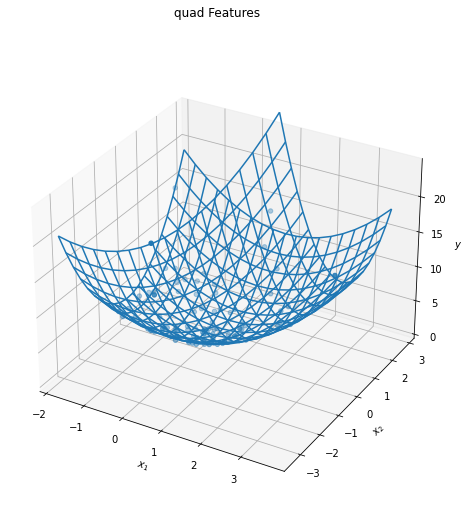

In [19]:
lambdas = np.outer(10. ** np.arange(-5, 0), np.arange(1,10,1)).ravel()
loss = np.zeros(lambdas.size)
for i in range(lambdas.size):
    regression_quad = RidgeRegression(lambda_=lambdas[i], ftype='quad')
    regression_quad.fit(X_quad_train, y_quad_train)
    y_hat = regression_quad.predict(X_quad)
    loss[i] = MSE(y_hat, y_quad)
li = loss.argmin()
print('Lambda:', lambdas[li])

plt.figure()
plt.grid()
plt.semilogx(lambdas, loss, label='loss')
plt.axvline(lambdas[li], color='r')
plt.suptitle('Evaluation of Lambda Values')
plt.xlabel('$\lambda$')
plt.ylabel('Mean Squared Error')
plt.legend(loc=4)

# use best lambda
regression_quad = RidgeRegression(lambda_=lambdas[li], ftype='quad')
train_evaluate(regression_quad, X_quad, y_quad)

# If the plot doesn't show the first time, run this cell again
plot_data_and_model(regression_quad, X_quad, y_quad)

7) *(5 points)* Evaluate the noisy dataset `(X_noise, y_noise)` for different values of `lambda_`. Report the MSE on the full data set when trained on the partial dataset `(X_noise_train, y_noise_train)`. Repeat this for different Ridge regularization parameters `lambda_` and generate a nice plot of the MSE for various `lambda_`. Plot the values of `lambda_` on the x-axis on a logarithmical scale and the error on the y-axis.

Plot the surface and data points of the best `lambda_` value using the function `plot_data_and_model`.

Lambda: 1.0
MSE (quad): 28.06014337064806


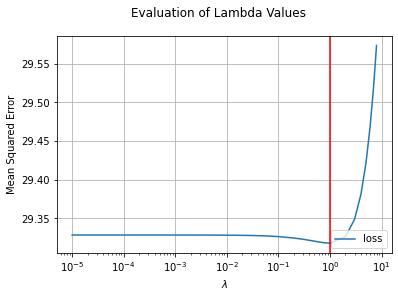

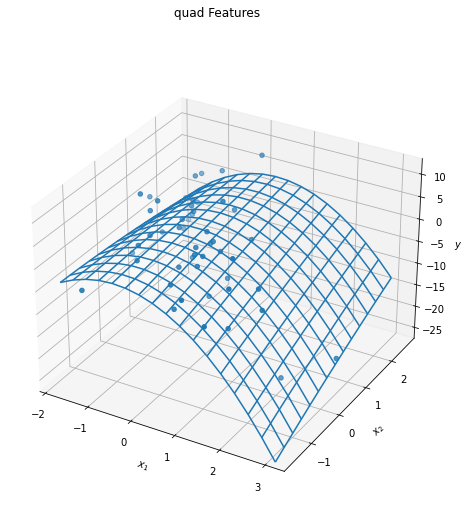

In [20]:
lambdas = np.outer(10. ** np.arange(-5, 1), np.arange(1,9,1)).ravel()
loss = np.zeros(lambdas.size)
for i in range(lambdas.size):
    regression_noise = RidgeRegression(lambda_=lambdas[i], ftype='quad')
    regression_noise.fit(X_noise_train, y_noise_train)
    y_hat = regression_noise.predict(X_noise)
    loss[i] = MSE(y_hat, y_noise)
li = loss.argmin()
print('Lambda:', lambdas[li])

plt.figure()
plt.grid()
plt.semilogx(lambdas, loss, label='loss')
plt.axvline(lambdas[li], color='r')
plt.suptitle('Evaluation of Lambda Values')
plt.xlabel('$\lambda$')
plt.ylabel('Mean Squared Error')
plt.legend(loc=4)

# use best lambda
regression_noise = RidgeRegression(lambda_=lambdas[li], ftype='quad')
train_evaluate(regression_noise, X_noise, y_noise)

# If the plot doesn't show the first time, run this cell again
plot_data_and_model(regression_noise, X_noise, y_noise)

## Task 3 Evaluation (20 points)

1) *(5 points)* What was the best choice for regularization term `lambda_` in the models above? Explain the observation from the previous task? If `lambda_` is set to zero $\hat{\beta}$ is not regularized, when would $\lambda = 0$ be a good choice?

- If the full data set is used for training the parameters dont require regularization, therefore $\lambda = 0$ was the best choice for `X_quad`.
- For noisy data or if only a fraction of the data is used for training the MSE is smaller if parameters are regularized.

**For all students other than B.Sc. Data Science:** 

2) *(15 points)* Implement the function `cross_validation` for `k_fold = 10` to evaluate the prediction error of your model. Report the mean squared error from cross-validation. Repeat this for different Ridge regularization parameters `lambda_` and generate a nice plot of the MSE for various `lambda_`. Plot the values of `lambda_` on the x-axis on a logarithmical scale and the error on the y-axis. 

Lambda: 30.0
Loss: 36.142262174356894


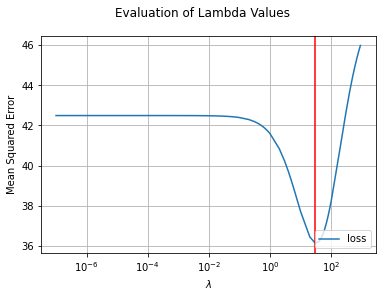

In [21]:
def cross_validation(regression_model, X, y, k_folds = 10):
    """
    partition data X in k_fold equal sized subsets D = {D_1, ..., D_{k_fold}}, 
        fit the model on k_fold-1 subsets (D\D_i), 
        compute MSE on the evaluatin set (D_i),
        return the mean MSE over all subsets D
    """
    n, d = X.shape
    boundaries = np.linspace(0, n, k_folds+1)[1:]
    nind = np.array([ sum(i > boundaries) for i in range(n) ])
    bind = np.equal.outer(range(k_folds), nind)
    
    loss_cv = np.empty(k_folds)
    for i in range(k_folds):
        X_train, y_train = X[~bind[i]], y[~bind[i]]
        X_test, y_test = X[bind[i]], y[bind[i]]

        regression_model.fit(X_train, y_train)
        y_hat_test = regression_model.predict(X_test)
        loss_cv[i] = MSE(y_hat_test, y_test)
    
    return loss_cv.mean()

lambdas = np.outer(10. ** np.arange(-7, 3), np.arange(1, 10, 1)).ravel()
loss = np.zeros(lambdas.size)
for i in range(lambdas.size):
    your_regression = RidgeRegression(lambda_=lambdas[i], ftype='quad')
    loss[i] = cross_validation(your_regression, X_noise, y_noise)
li = loss.argmin()
print('Lambda:', lambdas[li])

plt.figure()
plt.grid()
plt.semilogx(lambdas, loss, label='loss')
plt.axvline(lambdas[li], color='r')
plt.suptitle('Evaluation of Lambda Values')
plt.xlabel('$\lambda$')
plt.ylabel('Mean Squared Error')
plt.legend(loc=4)


your_regression = RidgeRegression(lambda_=lambdas[li], ftype='quad')
print('Loss:', loss[li])